# Practice Problems 8

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report

def pick_device():
    if tf.config.list_physical_devices('GPU'):
        return '/GPU:0'
    else:
        return '/CPU:0'

def plot_history(history):
  try:
    history_dict = history.history
  except AttributeError:
    history_dict = history
  size = len(history_dict['accuracy'])+1
  x = np.arange(1,size)
  best_epoch = np.argmax(history_dict['val_accuracy'])
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(x,history_dict['accuracy'], label='Training Accuracy')
  plt.plot(x,history_dict['val_accuracy'], label='Validation Accuracy')
  plt.axvline(best_epoch+1, color='red', linestyle='--', label=f'Best Epoch - val_acc = {history_dict["val_accuracy"][best_epoch]:.4f}')
  plt.xticks(range(min(x), max(x)+1),rotation=90)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x,history_dict['loss'], label='Training Loss')
  plt.plot(x,history_dict['val_loss'], label='Validation Loss')
  plt.xticks(range(min(x), max(x)+1),rotation=90)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.tight_layout()
  plt.show()

print(f"Using TensorFlow device: {pick_device()}")

Using TensorFlow device: /GPU:0


## Exercise 1

Build and train a keras sequential model to classify digits form the `mnist` dataset. The model must have a hidden dense layer of 128 neurons with a relu activation function.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28), y_train shape: (60000,)
x_test shape: (10000, 28, 28), y_test shape: (10000,)


We can plot the first sample of each class of the training dataset

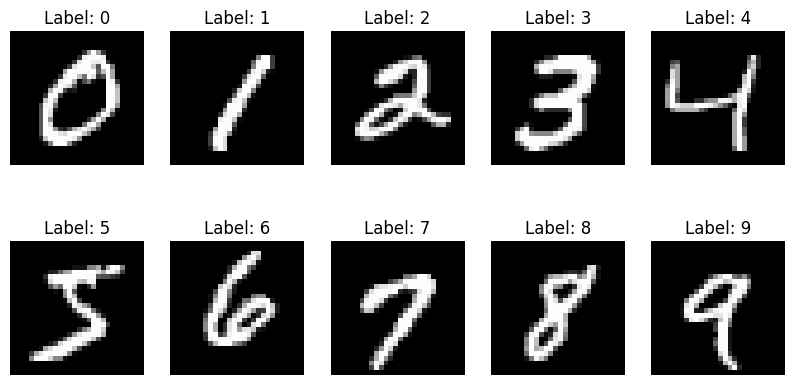

In [3]:
s = {}
i = 0
while len(s.keys()) < 10:
    if y_train[i] not in s.keys():
        s[y_train[i]] = x_train[i]
    i += 1

plt.figure(figsize=(10, 5))
for i in range(len(s.keys())):
    plt.subplot(2, 5, i + 1)
    plt.imshow(s[i], cmap='gray')
    plt.title(f"Label: {i}")
    plt.axis('off')

We convert our target values into one hot encoding representation in order to apply the 10 neurons output

In [4]:
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(f"y_train_one_hot shape: {y_train_one_hot.shape}, y_test_one_hot shape: {y_test_one_hot.shape}")

y_train_one_hot shape: (60000, 10), y_test_one_hot shape: (10000, 10)


We define our dense model based on the specifications given in the problem

In [5]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Compile the model using an Adam Optimizer with a learning rate of $0.001$

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(x_train,
                    y_train_one_hot,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_test, y_test_one_hot),
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8752 - loss: 0.4371 - val_accuracy: 0.9617 - val_loss: 0.1299
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9642 - loss: 0.1203 - val_accuracy: 0.9719 - val_loss: 0.0988
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9775 - loss: 0.0788 - val_accuracy: 0.9730 - val_loss: 0.0830
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9836 - loss: 0.0543 - val_accuracy: 0.9752 - val_loss: 0.0803
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9880 - loss: 0.0404 - val_accuracy: 0.9765 - val_loss: 0.0775
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9899 - loss: 0.0345 - val_accuracy: 0.9769 - val_loss: 0.0751
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9922 - loss: 0.0258 - val_accuracy: 0.9784 - val_loss: 0.0739
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9944 - loss: 0.0195 -

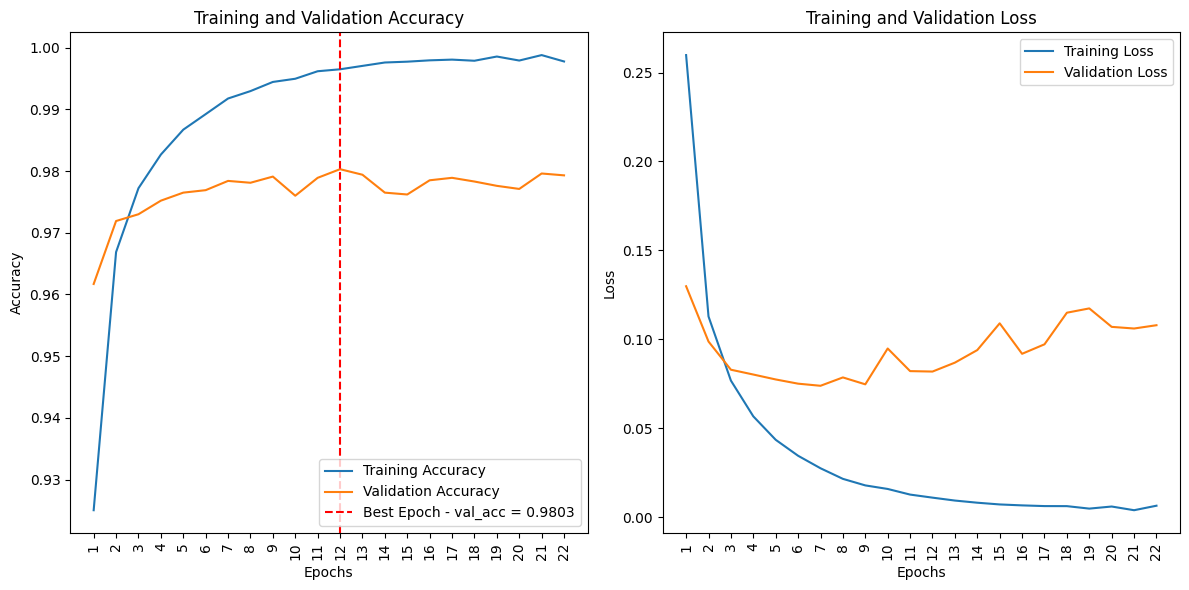

In [8]:
plot_history(history)

Now in order to see our model performance, we will use the test dataset and see the metrics over the classification task usong the sklearn utils

In [9]:
y_pred_one_hot = model.predict(x_test)
y_pred = np.argmax(y_pred_one_hot, axis=1)
print(f"y_pred shape: {y_pred.shape}")
print(f"y_test shape: {y_test.shape}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
y_pred shape: (10000,)
y_test shape: (10000,)


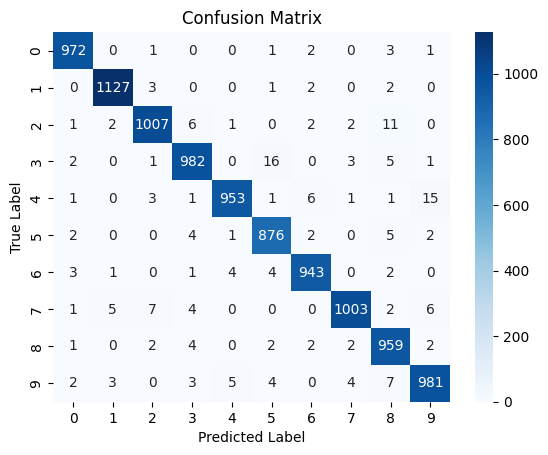

In [10]:
cmp = confusion_matrix(y_test, y_pred)
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [11]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9868    0.9918    0.9893       980
           1     0.9903    0.9930    0.9916      1135
           2     0.9834    0.9758    0.9796      1032
           3     0.9771    0.9723    0.9747      1010
           4     0.9886    0.9705    0.9794       982
           5     0.9680    0.9821    0.9750       892
           6     0.9833    0.9843    0.9838       958
           7     0.9882    0.9757    0.9819      1028
           8     0.9619    0.9846    0.9731       974
           9     0.9732    0.9722    0.9727      1009

    accuracy                         0.9803     10000
   macro avg     0.9801    0.9802    0.9801     10000
weighted avg     0.9804    0.9803    0.9803     10000



## Exercise 2

Now build and train a `keras` functional model for the same problem. The model must have a hidden dense layer of 128 neurons with an activation function defined by the following function:

$$
\text{activation}(x) = \left\{
    \begin{array}{lcc}
        0 & \text{if} & x < 0 \\
        \sin{\left(x - \frac{\pi}{2}\right)} + 1 & \text{if} & 0 \leq x \leq \frac{\pi}{2}\\
        x - \frac{\pi}{2} + 1 & \text{otherwise} &
    \end{array}
\right.
$$

In [12]:
@tf.function
def activation(x):
    cond1 = x < 0
    cond2 = tf.logical_and(x >= 0, x <= np.pi/2)

    zero_case = tf.zeros_like(x)
    sin_case = tf.sin(x - np.pi/2) + 1
    linear_case = x - np.pi/2 + 1

    result = tf.where(cond1, zero_case, tf.where(cond2, sin_case, linear_case))
    return result

We test the defined function and we compare the gradient found by tf with the real analytical gradient defined by:

$$
 \frac{d}{dx}\text{activation}(x) = \left\{
    \begin{array}{lcc}
        0 & \text{if} & x < 0 \\
        \cos{\left(x - \frac{\pi}{2}\right)} & \text{if} & 0 \leq x \leq \frac{\pi}{2}\\
        1 & \text{otherwise} &
    \end{array}
\right.
$$

In [13]:
@tf.function
def activation_derivative(x):
    cond1 = x < 0
    cond2 = tf.logical_and(x >= 0, x <= np.pi/2)

    zero_case = tf.zeros_like(x)
    sin_case = tf.cos(x - np.pi/2)
    linear_case = tf.ones_like(x)

    result = tf.where(cond1, zero_case, tf.where(cond2, sin_case, linear_case))
    return result

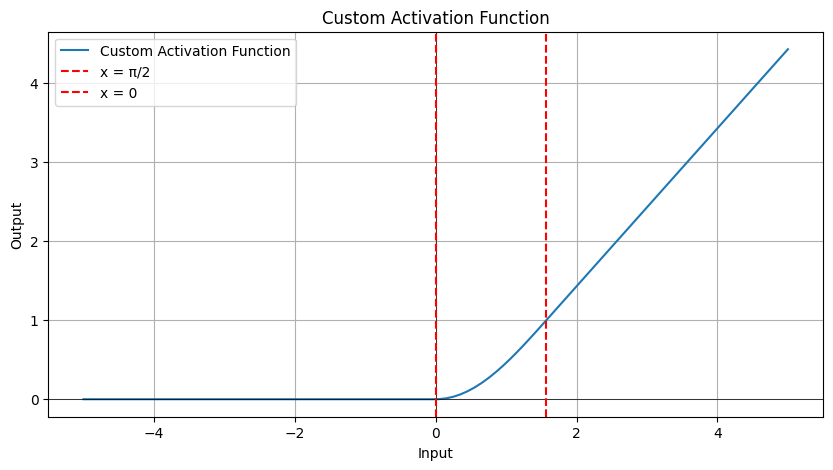

In [14]:
x = tf.constant(np.linspace(-5, 5, 100), dtype=tf.float32)
plt.figure(figsize=(10, 5))
plt.plot(x.numpy(), activation(x).numpy(), label='Custom Activation Function')
plt.title('Custom Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.axhline(0, color='black', lw=0.5, ls='-')
plt.axvline(0, color='black', lw=0.5, ls='-')
plt.axvline(np.pi/2, color='red', ls='--', label='x = π/2')
plt.axvline(0, color='red', ls='--', label='x = 0')
plt.legend()
plt.grid()

Max error between computed and analytical derivative: 0.0


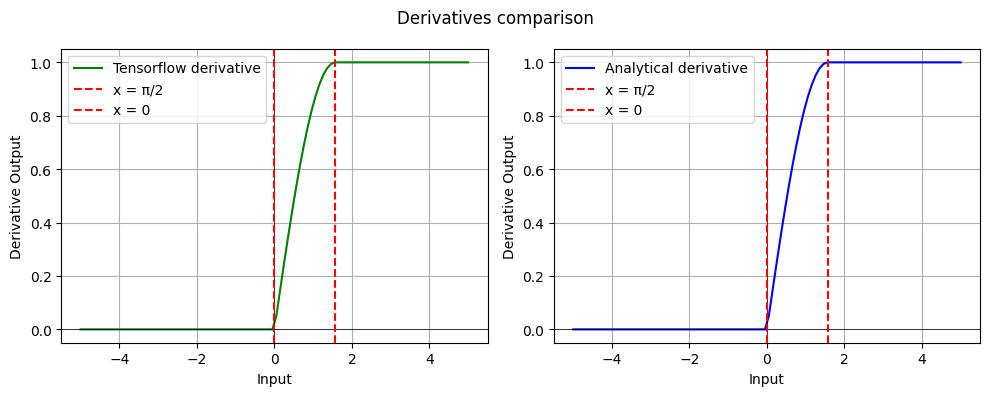

In [15]:
with tf.GradientTape() as t:
    t.watch(x)
    y = activation(x)

dactivation_dx = t.gradient(y, x)
error = tf.reduce_max(tf.abs(dactivation_dx - activation_derivative(x)))
print(f"Max error between computed and analytical derivative: {error.numpy()}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Primer gráfico
ax1.plot(x.numpy(), dactivation_dx.numpy(), label='Tensorflow derivative', color='green')
ax1.set_xlabel('Input')
ax1.set_ylabel('Derivative Output')
ax1.axhline(0, color='black', lw=0.5, ls='-')
ax1.axvline(0, color='black', lw=0.5, ls='-')
ax1.axvline(np.pi/2, color='red', ls='--', label='x = π/2')
ax1.axvline(0, color='red', ls='--', label='x = 0')
ax1.legend()
ax1.grid()

# Segundo gráfico
ax2.plot(x.numpy(), activation_derivative(x).numpy(), label='Analytical derivative', color='blue')
ax2.set_xlabel('Input')
ax2.set_ylabel('Derivative Output')
ax2.axhline(0, color='black', lw=0.5, ls='-')
ax2.axvline(0, color='black', lw=0.5, ls='-')
ax2.axvline(np.pi/2, color='red', ls='--', label='x = π/2')
ax2.axvline(0, color='red', ls='--', label='x = 0')
ax2.legend()
ax2.grid()

fig.suptitle(f'Derivatives comparison')
plt.legend()
plt.tight_layout()
plt.show()

Now we will make a new model using this new custom activation function

In [16]:
model_custom_activation = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=activation),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_custom_activation.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_custom_activation.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
early_stop_custom_activation = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history_custom_activation = model_custom_activation.fit(x_train,
                    y_train_one_hot,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_test, y_test_one_hot),
                    callbacks=[early_stop_custom_activation],
                    verbose=1)

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8717 - loss: 0.4519 - val_accuracy: 0.9588 - val_loss: 0.1405
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9637 - loss: 0.1284 - val_accuracy: 0.9717 - val_loss: 0.0940
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9767 - loss: 0.0800 - val_accuracy: 0.9754 - val_loss: 0.0828
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9816 - loss: 0.0601 - val_accuracy: 0.9764 - val_loss: 0.0759
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9870 - loss: 0.0441 - val_accuracy: 0.9742 - val_loss: 0.0880
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9885 - loss: 0.0355 - val_accuracy: 0.9785 - val_loss: 0.0743
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9918 - loss: 0.0280 - val_accuracy: 0.9793 - val_loss: 0.0741
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9930 - loss: 0.0224 

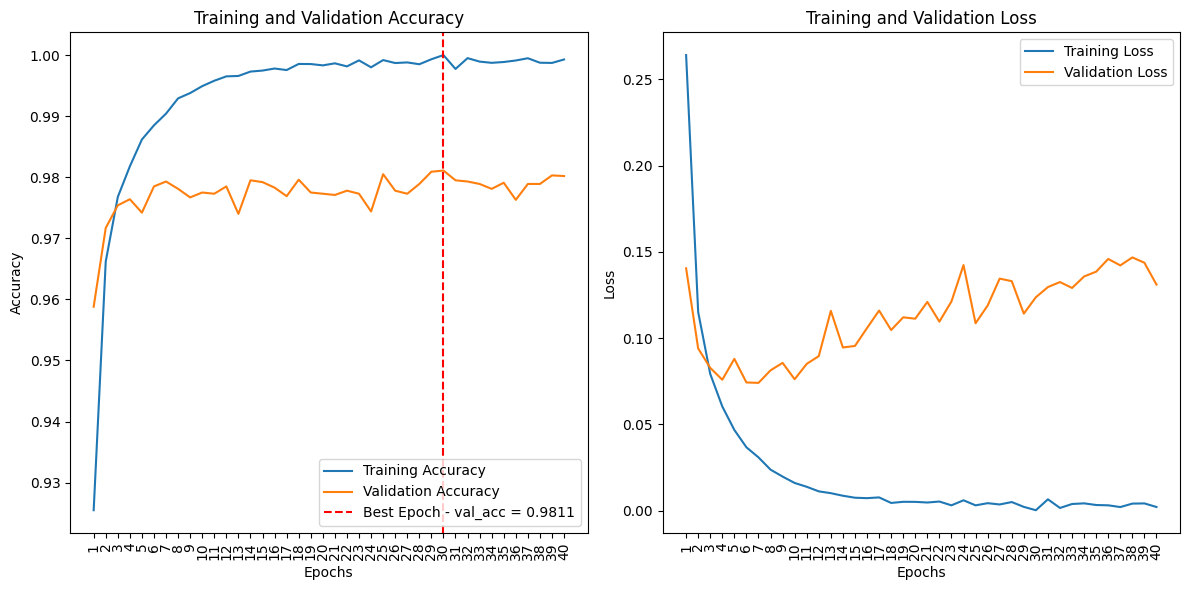

In [19]:
plot_history(history_custom_activation)

In [20]:
y_pred_one_hot_custom = model_custom_activation.predict(x_test)
y_pred_custom = np.argmax(y_pred_one_hot_custom, axis=1)
print(f"y_pred shape: {y_pred_custom.shape}")
print(f"y_test shape: {y_test.shape}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
y_pred shape: (10000,)
y_test shape: (10000,)


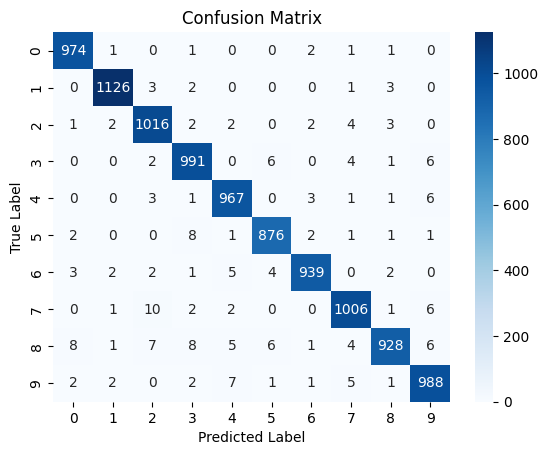

In [21]:
cmp = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Exercise 3

Repeat the previous questions but now using `PyTorch`.

We will make a defalult class for our neuronal network that will receive as parameter the activation function

In [22]:
batch_size = 32
train_data = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train))
test_data = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [23]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

class EarlyStoppingAccuracyCallback:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_acc = 0
        self.best_epoch = 0
        self.best_state_dict = None
        self.counter = 0
    def updateModel(self, model):
        print(f'Weights set to epoch {self.best_epoch}')
        model.load_state_dict(self.best_state_dict)
    def __call__(self, model, acc, epoch):
        if acc > self.best_acc + self.min_delta:
            self.best_acc = acc
            self.best_epoch = epoch
            self.best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.updateModel(model)
                return True
        return False

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    all_preds = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            all_preds.append(pred.detach().cpu())
    test_loss /= num_batches
    all_preds = torch.cat(all_preds, dim=0)
    return test_loss, all_preds

def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    acc = correct / size
    test_loss /= num_batches
    return test_loss, acc

def train(dataloader, val_dataloader, model, loss_fn, optimizer, epochs = 50, callback = None):
    size = len(dataloader.dataset)
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]
    value = False
    for epoch in range(1,epochs+1):
        model.train()
        train_loss = 0
        correct = 0
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(dataloader)
        train_acc = correct / size
        val_loss, val_acc = val(val_dataloader, model, loss_fn)

        print(f'Epoch {epoch:>3}')
        print(f'Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}')

        if callback is not None:
            value = callback(model, val_acc, epoch)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if value:
          print(f'Early stopping at epoch {epoch}')
          break
    if not value and callback is not None:
        callback.updateModel(model)

    history_dict = {'loss': train_losses,
                    'val_loss':val_losses,
                    'accuracy':train_accs,
                    'val_accuracy': val_accs}
    return history_dict


class NeuronalNetwork(torch.nn.Module):
    def __init__(self, activation):
        super().__init__()
        if isinstance(activation, type):
            activation_layer = activation()
        else:
            activation_layer = activation

        self.model = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28*28, 128),
            activation_layer,
            torch.nn.Linear(128, 10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

Using cuda device


We will define the first model that works with the ReLU activation

In [24]:
model_torch = NeuronalNetwork(torch.nn.ReLU)
model_torch.to(device)

NeuronalNetwork(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [25]:
early_stop_torch = EarlyStoppingAccuracyCallback(patience=10)
history_torch = train(train_loader,
                      test_loader,
                      model_torch,
                      torch.nn.CrossEntropyLoss(),
                      torch.optim.Adam(model_torch.parameters(), lr=0.001),
                      epochs=50,
                      callback=early_stop_torch)

Epoch   1
Train Loss: 1.5795 - Train Acc: 0.9019 | Val Loss: 1.5285 - Val Acc: 0.9381
Epoch   2
Train Loss: 1.5196 - Train Acc: 0.9467 | Val Loss: 1.5111 - Val Acc: 0.9540
Epoch   3
Train Loss: 1.5058 - Train Acc: 0.9589 | Val Loss: 1.5044 - Val Acc: 0.9609
Epoch   4
Train Loss: 1.4970 - Train Acc: 0.9675 | Val Loss: 1.4981 - Val Acc: 0.9653
Epoch   5
Train Loss: 1.4911 - Train Acc: 0.9729 | Val Loss: 1.4960 - Val Acc: 0.9664
Epoch   6
Train Loss: 1.4870 - Train Acc: 0.9762 | Val Loss: 1.4914 - Val Acc: 0.9718
Epoch   7
Train Loss: 1.4839 - Train Acc: 0.9791 | Val Loss: 1.4904 - Val Acc: 0.9718
Epoch   8
Train Loss: 1.4811 - Train Acc: 0.9819 | Val Loss: 1.4891 - Val Acc: 0.9741
Epoch   9
Train Loss: 1.4790 - Train Acc: 0.9837 | Val Loss: 1.4886 - Val Acc: 0.9740
Epoch  10
Train Loss: 1.4773 - Train Acc: 0.9852 | Val Loss: 1.4881 - Val Acc: 0.9743
Epoch  11
Train Loss: 1.4761 - Train Acc: 0.9865 | Val Loss: 1.4867 - Val Acc: 0.9751
Epoch  12
Train Loss: 1.4748 - Train Acc: 0.9873 | Val

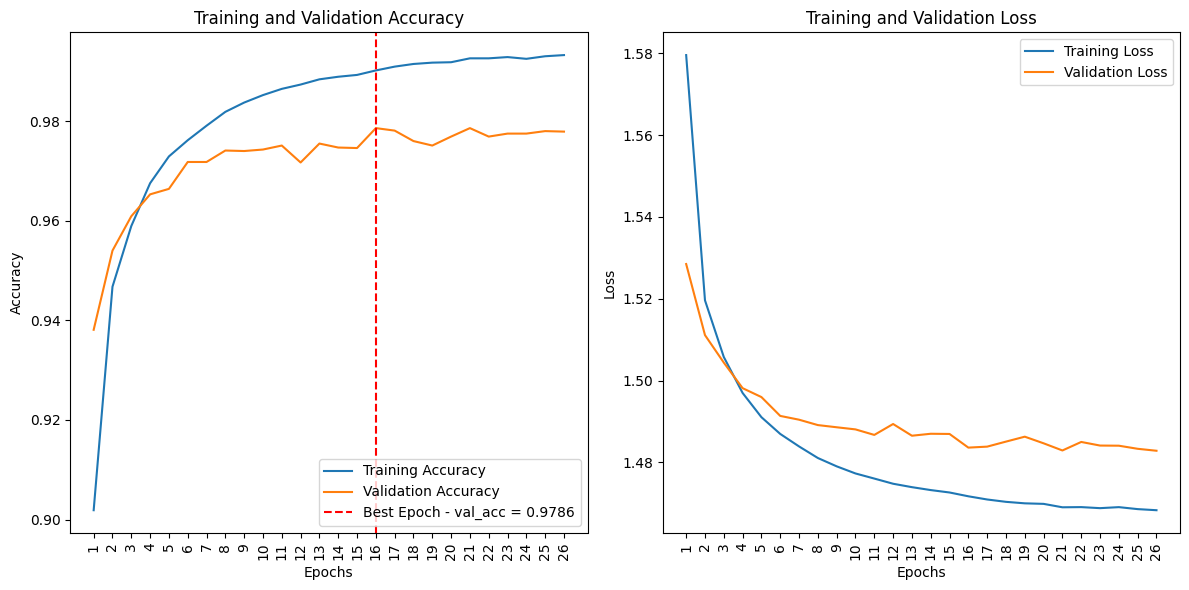

In [26]:
plot_history(history_torch)

In [27]:
test_loss_torch, y_pred_torch_one_hot = test(test_loader, model_torch, torch.nn.CrossEntropyLoss())
y_pred_torch = y_pred_torch_one_hot.argmax(1).numpy()
print(f"y_pred shape: {y_pred_torch.shape}")
print(f"y_test shape: {y_test.shape}")

y_pred shape: (10000,)
y_test shape: (10000,)


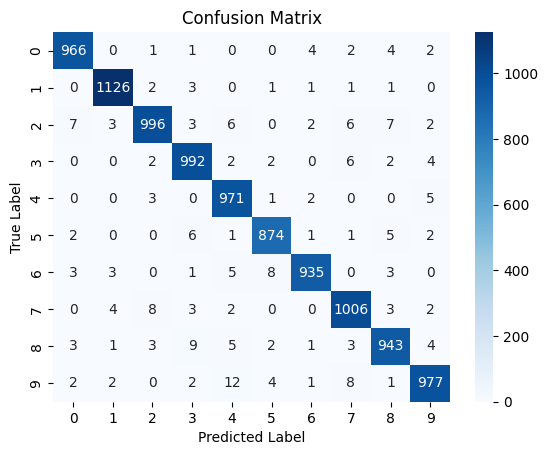

In [28]:
cmp = confusion_matrix(y_test, y_pred_torch)
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [29]:
print(classification_report(y_test, y_pred_torch, digits=4))

              precision    recall  f1-score   support

           0     0.9827    0.9857    0.9842       980
           1     0.9886    0.9921    0.9903      1135
           2     0.9813    0.9651    0.9731      1032
           3     0.9725    0.9822    0.9773      1010
           4     0.9671    0.9888    0.9778       982
           5     0.9798    0.9798    0.9798       892
           6     0.9873    0.9760    0.9816       958
           7     0.9739    0.9786    0.9762      1028
           8     0.9732    0.9682    0.9707       974
           9     0.9790    0.9683    0.9736      1009

    accuracy                         0.9786     10000
   macro avg     0.9785    0.9785    0.9785     10000
weighted avg     0.9786    0.9786    0.9786     10000



Now we define the activation using the costume function

In [30]:
class Activation(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.pi_over_2 = np.pi / 2

    def forward(self, x):
        mask1 = x < 0
        mask2 = (x >= 0) & (x <= self.pi_over_2)
        mask3 = x > self.pi_over_2

        out = torch.zeros_like(x)

        out[mask1] = 0
        out[mask2] = torch.sin(x[mask2] - self.pi_over_2) + 1
        out[mask3] = x[mask3] - self.pi_over_2 + 1

        return out

In [31]:
model_torch_custom = NeuronalNetwork(Activation)
model_torch_custom.to(device)

NeuronalNetwork(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): Activation()
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [32]:
early_stop_torch_custom = EarlyStoppingAccuracyCallback(patience=10)
history_torch_custom = train(train_loader,
                            test_loader,
                            model_torch_custom,
                            torch.nn.CrossEntropyLoss(),
                            torch.optim.Adam(model_torch_custom.parameters(), lr=0.001),
                            epochs=50,
                            callback=early_stop_torch_custom)

Epoch   1
Train Loss: 1.5883 - Train Acc: 0.8921 | Val Loss: 1.5278 - Val Acc: 0.9398
Epoch   2
Train Loss: 1.5209 - Train Acc: 0.9456 | Val Loss: 1.5131 - Val Acc: 0.9512
Epoch   3
Train Loss: 1.5069 - Train Acc: 0.9581 | Val Loss: 1.5048 - Val Acc: 0.9586
Epoch   4
Train Loss: 1.4989 - Train Acc: 0.9655 | Val Loss: 1.4969 - Val Acc: 0.9665
Epoch   5
Train Loss: 1.4927 - Train Acc: 0.9710 | Val Loss: 1.4977 - Val Acc: 0.9655
Epoch   6
Train Loss: 1.4885 - Train Acc: 0.9749 | Val Loss: 1.4913 - Val Acc: 0.9717
Epoch   7
Train Loss: 1.4850 - Train Acc: 0.9782 | Val Loss: 1.4937 - Val Acc: 0.9696
Epoch   8
Train Loss: 1.4826 - Train Acc: 0.9802 | Val Loss: 1.4918 - Val Acc: 0.9714
Epoch   9
Train Loss: 1.4804 - Train Acc: 0.9822 | Val Loss: 1.4898 - Val Acc: 0.9726
Epoch  10
Train Loss: 1.4790 - Train Acc: 0.9837 | Val Loss: 1.4880 - Val Acc: 0.9732
Epoch  11
Train Loss: 1.4773 - Train Acc: 0.9852 | Val Loss: 1.4901 - Val Acc: 0.9714
Epoch  12
Train Loss: 1.4765 - Train Acc: 0.9857 | Val

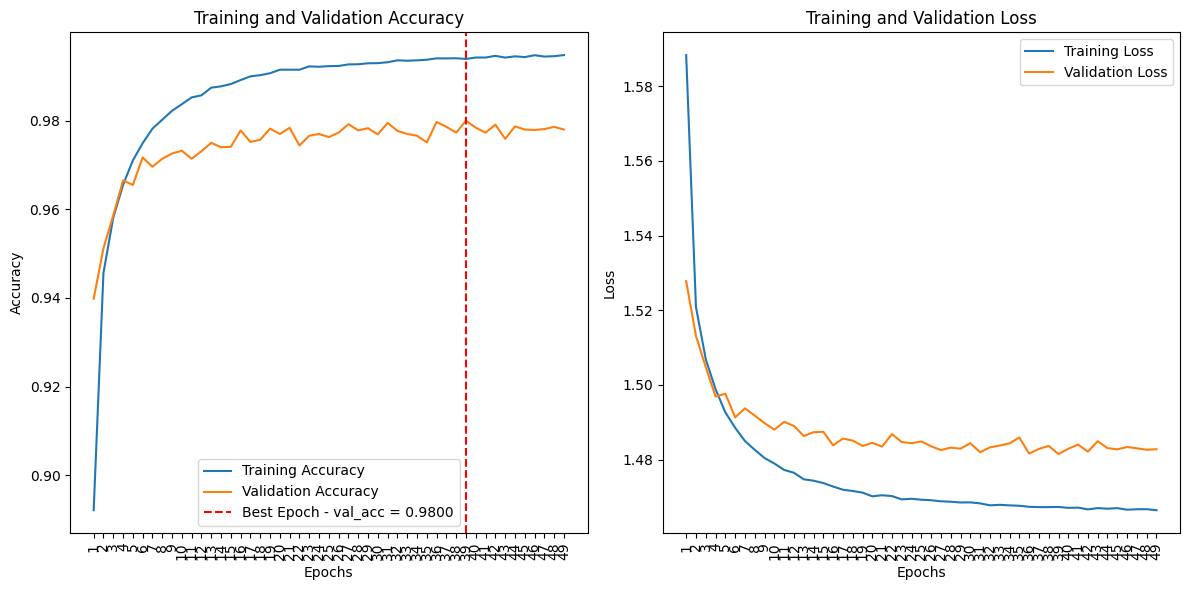

In [33]:
plot_history(history_torch_custom)

In [34]:
test_loss_custom_torch, y_pred_torch_custom_one_hot = test(test_loader, model_torch_custom, torch.nn.CrossEntropyLoss())
y_pred_torch_custom = y_pred_torch_custom_one_hot.argmax(1).numpy()
print(f"y_pred shape: {y_pred_torch_custom.shape}")
print(f"y_test shape: {y_test.shape}")

y_pred shape: (10000,)
y_test shape: (10000,)


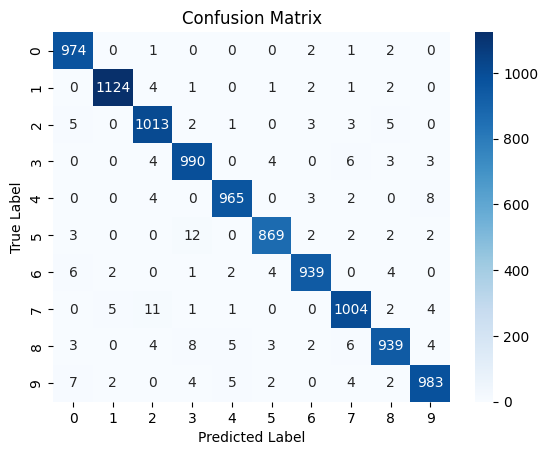

In [35]:
cmp = confusion_matrix(y_test, y_pred_torch_custom)
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [36]:
print(classification_report(y_test, y_pred_torch_custom, digits=4))

              precision    recall  f1-score   support

           0     0.9760    0.9939    0.9848       980
           1     0.9921    0.9903    0.9912      1135
           2     0.9731    0.9816    0.9773      1032
           3     0.9715    0.9802    0.9759      1010
           4     0.9857    0.9827    0.9842       982
           5     0.9841    0.9742    0.9792       892
           6     0.9853    0.9802    0.9827       958
           7     0.9757    0.9767    0.9762      1028
           8     0.9771    0.9641    0.9705       974
           9     0.9791    0.9742    0.9767      1009

    accuracy                         0.9800     10000
   macro avg     0.9800    0.9798    0.9799     10000
weighted avg     0.9800    0.9800    0.9800     10000

